**Imported all necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings('ignore')

- numpy -For numerical operations, arrays, and mathematical functions
- pandas - For handling and analyzing data in tables (DataFrames)
- matplotlib.pyplot -For creating plots, graphs, and visualizations
- seaborn - For advanced, visually appealing statistical plots
- scipy stats - For statistical functions, tests, and analysis



**Loaded both datasets**

In [ ]:
app_df = pd.read_csv('/content/sample_data/credit_risk_applicants.csv')
loan_df =  pd.read_csv('/content/sample_data/credit_risk_previous_loans.csv')
print("Applicants:", app_df.shape, "Previous loans app:", loan_df.shape)

Applicants: (307511, 122) Previous loans app: (1670214, 37)


In [ ]:
app_df.head()

In [ ]:
loan_df.head()

In [ ]:
print(app_df.dtypes.value_counts())

float64    65
int64      41
object     16
Name: count, dtype: int64


In [ ]:
print(loan_df.dtypes.value_counts())

object     16
float64    15
int64       6
Name: count, dtype: int64


**Missing value analysis**

In [ ]:
# Missing value count
miss = app_df.isnull().sum()
# Missing percentage
miss_pct = (miss / len(app_df) * 100).round(2)
# Create missing value table
miss_table = pd.concat([miss, miss_pct], axis=1)
miss_table.columns = ['missing_count', 'missing_pct']
# Display top 10 columns with highest missing %
display(miss_table.sort_values('missing_pct', ascending=False).head(10))


,missing_count,missing_pct
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
COMMONAREA_MEDI,214865,69.87
NONLIVINGAPARTMENTS_MEDI,213514,69.43
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35
LIVINGAPARTMENTS_MODE,210199,68.35


In [ ]:
loan_df_miss = loan_df.isnull().sum()
loan_df_miss_pct = (loan_df_miss / len(loan_df) * 100).round(2)
loan_df_miss_table = pd.concat([loan_df_miss, loan_df_miss_pct], axis=1)
loan_df_miss_table.columns = ['missing_count','missing_pct']
display(loan_df_miss_table.sort_values('missing_pct', ascending=False).head(10))

**Missing Value Handling**

In [ ]:
app_df['DAYS_EMPLOYED'] = app_df['DAYS_EMPLOYED'].fillna(app_df['DAYS_EMPLOYED'].median())

In [ ]:
app_df['AGE_YEARS'] = -app_df['DAYS_BIRTH'] / 365

In [ ]:
num_cols = app_df.select_dtypes(include=np.number).columns

for col in num_cols:
    app_df[col] = app_df[col].fillna(app_df[col].median())

In [ ]:
for col in num_cols:
    if app_df[col].isnull().sum() > 0:     # only impute columns that need it
        app_df[col] = app_df[col].fillna(app_df[col].median())

In [ ]:
cat_cols = app_df.select_dtypes(include='object').columns

for col in cat_cols:
    app_df[col] = app_df[col].fillna(app_df[col].mode()[0])

In [ ]:
# Outlier Handling
numeric_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']

numeric_cols = [col for col in numeric_cols if col in app_df.columns]
numeric_cols


['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

- Before capping (optional but recommended):
- These boxplots help visualize how many extreme values (outliers) exist in
- income, credit amount, annuity, and goods price. Outliers stretch the scale, skew the distribution, and can negatively affect statistical tests and model performance.
- Plotting them first helps us understand why capping is needed.


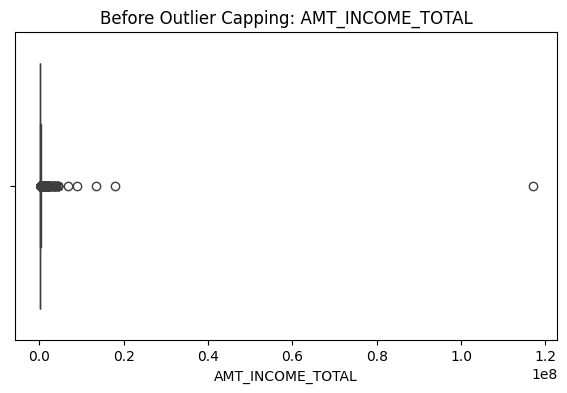

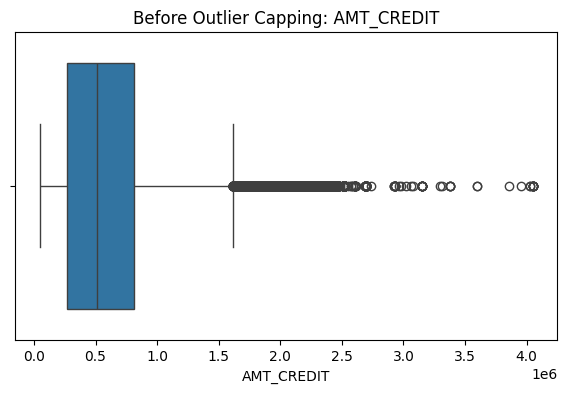

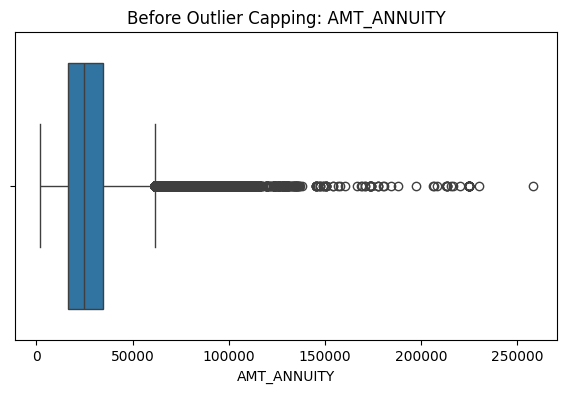

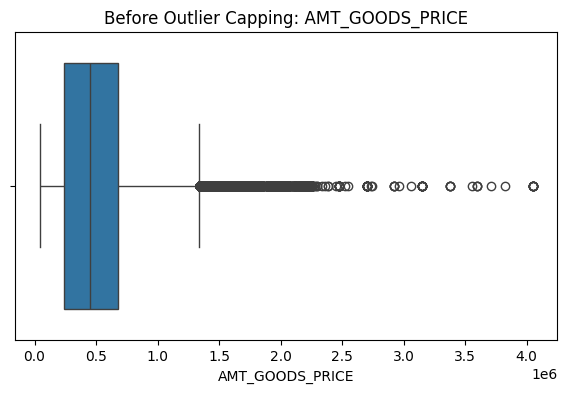

In [ ]:
# Before capping — OPTIONAL but highly recommended
for col in numeric_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=app_df[col])
    plt.title(f"Before Outlier Capping: {col}")
    plt.show()


- IQR Outlier Capping:
- This function caps extreme values using the Interquartile Range (IQR) method.
- Outliers can distort averages, variance, correlations, and model performance.
- Instead of removing rows, capping keeps all customers while reducing the
impact of unrealistic high or low values.
- A new capped column is created to preserve original data and support clean, stable analysis.

In [ ]:
# Function for IQR Capping
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Create a capped version (best practice)
    df[col + "_CAPPED"] = np.where(df[col] < lower_limit, lower_limit,
                           np.where(df[col] > upper_limit, upper_limit, df[col]))
    return lower_limit, upper_limit

cap_info = {}
for col in numeric_cols:
    lower, upper = cap_outliers(app_df, col)
    cap_info[col] = (lower, upper)


After capping
- These boxplots show the distribution after applying IQR capping. The extreme high and low values have been limited, resulting in a cleaner and more stable range.
- This helps improve statistical reliability and ensures that models are not influenced by extreme outliers.


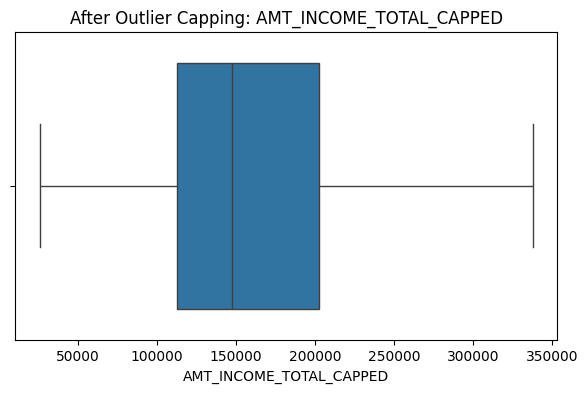

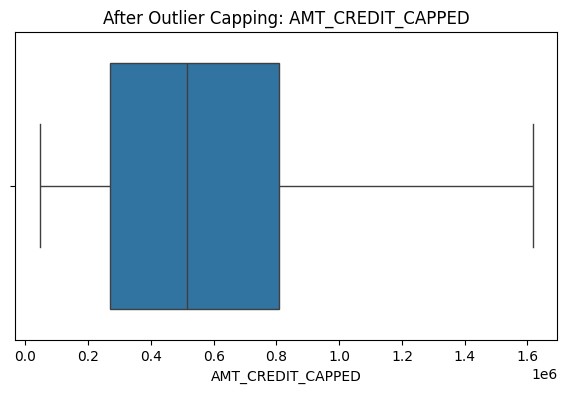

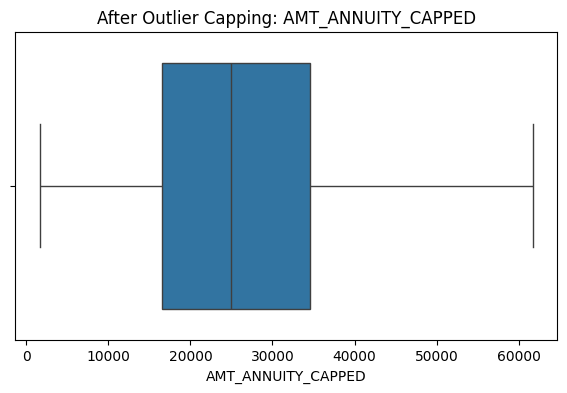

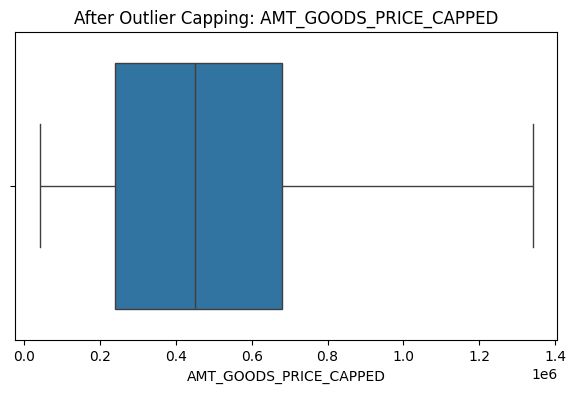

In [ ]:
# After capping
for col in numeric_cols:
    plt.figure(figsize=(7,4))
    sns.boxplot(x=app_df[col + "_CAPPED"])
    plt.title(f"After Outlier Capping: {col}_CAPPED")
    plt.show()


- Identify columns with more than 90% missing values.
- These columns have too little data to be useful and are candidates for removal.

In [ ]:
high_null = loan_df.columns[loan_df.isnull().mean() > 0.9]

In [ ]:
high_null.shape

(2,)

In [ ]:
loan_df = loan_df.drop(columns=high_null)

Handle missing values:
 - Fill numeric columns with median (robust against outliers)
 - Fill categorical columns with mode (most common value)
- This ensures the dataset is complete and ready for analysis.

In [ ]:
loan_num = loan_df.select_dtypes(include=np.number).columns
loan_cat = loan_df.select_dtypes(include='object').columns

for col in loan_num:
    loan_df[col] = loan_df[col].fillna(loan_df[col].median())

for col in loan_cat:
    loan_df[col] = loan_df[col].fillna(loan_df[col].mode()[0])

In [ ]:
loan_num_cols = loan_df.select_dtypes(include=['int64', 'float64']).columns

- Aggregate previous loan data at the customer level:
- For each SK_ID_CURR, compute mean, max, sum, and count of numeric features.
- This summarizes past borrowing behavior and creates powerful risk indicators.

In [ ]:
# Aggregate previous loan data at the customer level:
# For each SK_ID_CURR, compute mean, max, sum, and count of numeric features.
# This summarizes past borrowing behavior and creates powerful risk indicators.
loan_agg = loan_df.groupby("SK_ID_CURR")[loan_num_cols].agg(['mean', 'max', 'sum', 'count'])
loan_agg.columns = ['prev_' + '_'.join(col) for col in loan_agg.columns]

In [ ]:
# Convert loan status into separate binary columns (Approved, Refused, etc.)
# This creates useful behavioral indicators showing how past applications ended.
loan_status = pd.get_dummies(loan_df[['SK_ID_CURR','NAME_CONTRACT_STATUS']],
                             columns=['NAME_CONTRACT_STATUS'])

In [ ]:
# Aggregate loan status by customer (counts how many times each status occurred)
# This helps identify customers with repeated refusals or approvals.
loan_status = loan_status.groupby('SK_ID_CURR').sum()

In [ ]:
# Join numeric aggregates (loan_agg) and loan status flags (loan_status)
# This combines both financial history and behavioral history at customer level.
loan_final = loan_agg.join(loan_status, how='left')

In [ ]:
# Merge previous-loan summary with main application data
# This attaches past-loan behavior to each current applicant.
df = app_df.merge(loan_final, on='SK_ID_CURR', how='left')

In [ ]:
# Create credit-to-income ratio (loan amount relative to income)
# Measures affordability: higher ratio means higher repayment stress → more risk.
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / (df['AMT_INCOME_TOTAL'] + 1)


# Create annuity-to-income ratio (EMI burden relative to income)
# Shows how much of income goes to EMI; high EMI burden indicates higher risk.
df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)

# Ratio of goods price to total credit amount.
# Shows how much of the loan is used to pay for actual goods vs extra costs.
df['GOODS_CREDIT_RATIO'] = df['AMT_GOODS_PRICE'] / (df['AMT_CREDIT'] + 1)


# High credit burden flag: 1 if customer's credit-to-income ratio is above median.
# Identifies customers taking loans larger than what their income comfortably supports.
df['HIGH_CREDIT_BURDEN'] = (df['CREDIT_INCOME_RATIO'] > df['CREDIT_INCOME_RATIO'].median()).astype(int)


# High EMI burden flag: 1 if customer's EMI-to-income ratio is above median.
# Marks customers whose monthly installment is heavy compared to their income.
df['HIGH_ANNUITY_BURDEN'] = (df['ANNUITY_INCOME_RATIO'] > df['ANNUITY_INCOME_RATIO'].median()).astype(int)


# Previous refusal flag: 1 if customer had at least one past loan refusal.
# Strong behavioral risk signal—customers refused before tend to default more.
df['PREV_REFUSED_FLAG'] = (df.filter(like='NAME_CONTRACT_STATUS_Refused').sum(axis=1) > 0).astype(int)

In [ ]:
# Create age groups (bins) to categorize customers by life stage.
# Helps identify whether certain age groups have higher or lower default risk.
df['AGE_GROUP'] = pd.cut(df['AGE_YEARS'],
                         bins=[18, 25, 35, 45, 55, 65, 120],
                         labels=['18-25','26-35','36-45','46-55','56-65','65+'])


# Create income groups using quantiles (Very Low → Very High).
# Allows comparison of risk patterns across different income categories.
df['INCOME_GROUP'] = pd.qcut(df['AMT_INCOME_TOTAL'], q=5,
                             labels=['Very Low','Low','Medium','High','Very High'])


# Total credit amount taken across all previous loans.
# Measures past borrowing volume—higher total suggests higher leverage.
df['TOTAL_PREV_CREDIT'] = df.filter(like='prev_AMT_CREDIT_sum').sum(axis=1)


# Total number of previous loans taken by the customer.
# High count may indicate credit hunger or frequent borrowing behavior.
df['TOTAL_PREV_LOANS'] = df.filter(like='prev_SK_ID_PREV_count').sum(axis=1)


# Total number of previous approved loans.
# Useful for understanding positive credit history and repayment experience.
df['PREV_APPROVED'] = df.filter(like='NAME_CONTRACT_STATUS_Approved').sum(axis=1)


# Total number of previous refused loans.
# Strong signal of risky behavior—customers refused before may default more.
df['PREV_REFUSED'] = df.filter(like='NAME_CONTRACT_STATUS_Refused').sum(axis=1)

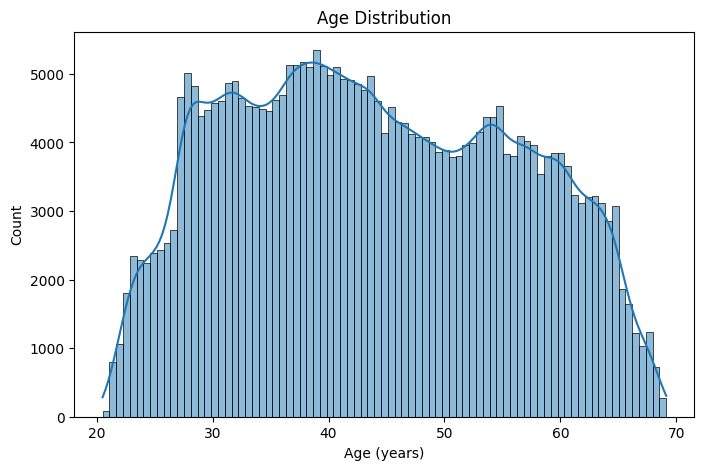

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['AGE_YEARS'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.show()

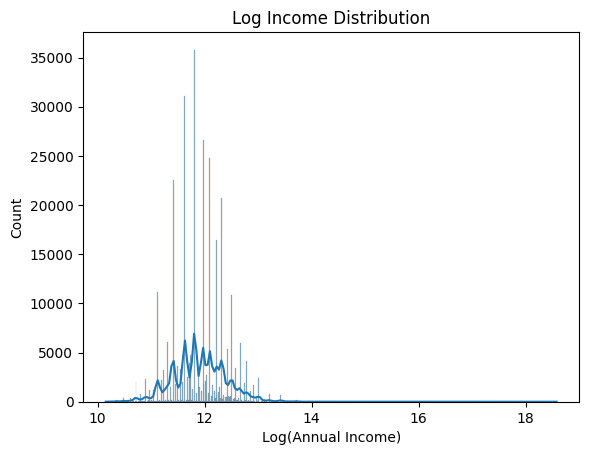

In [ ]:
# Explains skewness
# Shows real distribution
# Helps justify transformations
sns.histplot(np.log1p(df['AMT_INCOME_TOTAL']), kde=True)
plt.title("Log Income Distribution")
plt.xlabel("Log(Annual Income)")
plt.show()


<Axes: xlabel='AMT_INCOME_TOTAL_CAPPED', ylabel='Count'>

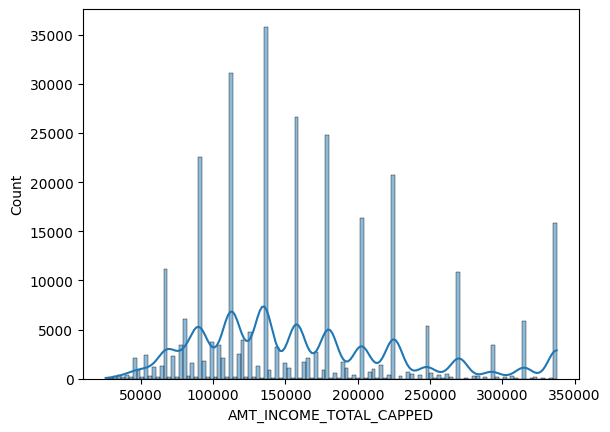

In [ ]:
#Shows improved distribution after fixing outliers
#Demonstrates your preprocessing work
sns.histplot(df['AMT_INCOME_TOTAL_CAPPED'], kde=True)

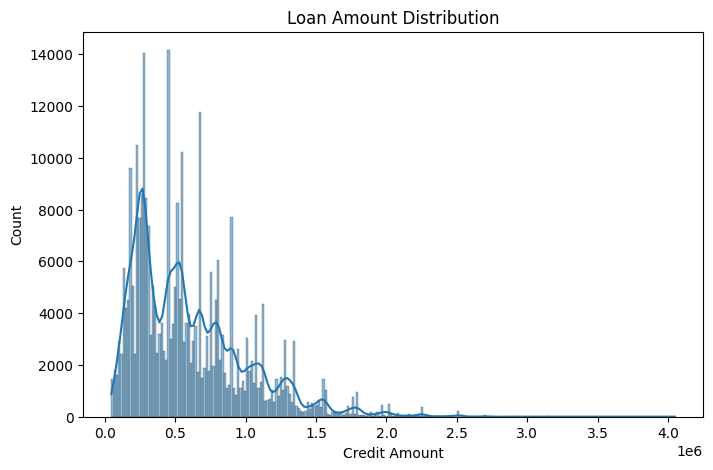

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['AMT_CREDIT'], kde=True)
plt.title('Loan Amount Distribution')
plt.xlabel('Credit Amount')
plt.show()

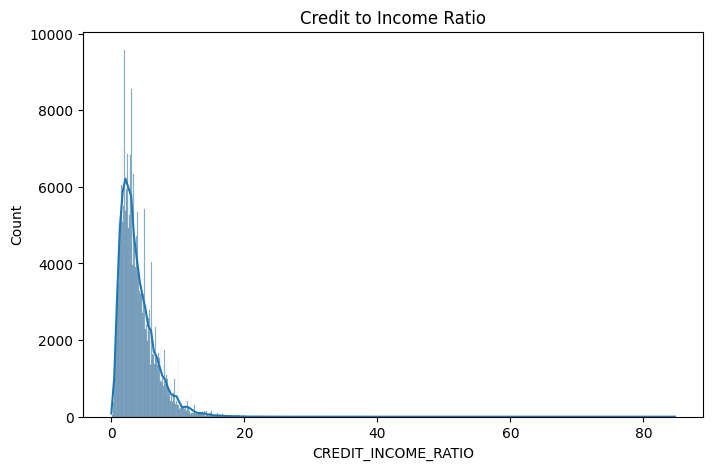

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['CREDIT_INCOME_RATIO'], kde=True)
plt.title('Credit to Income Ratio')
plt.show()

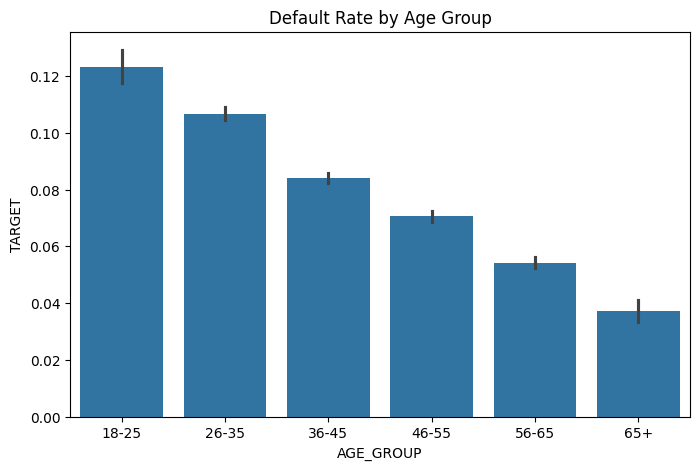

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='AGE_GROUP', y='TARGET')
plt.title('Default Rate by Age Group')
plt.show()

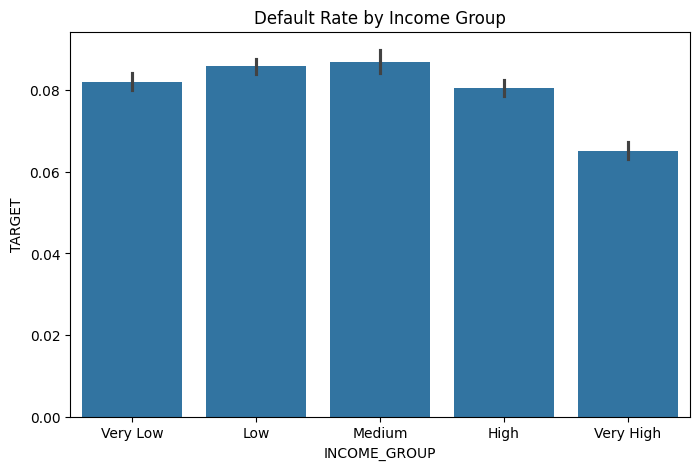

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='INCOME_GROUP', y='TARGET')
plt.title('Default Rate by Income Group')
plt.show()

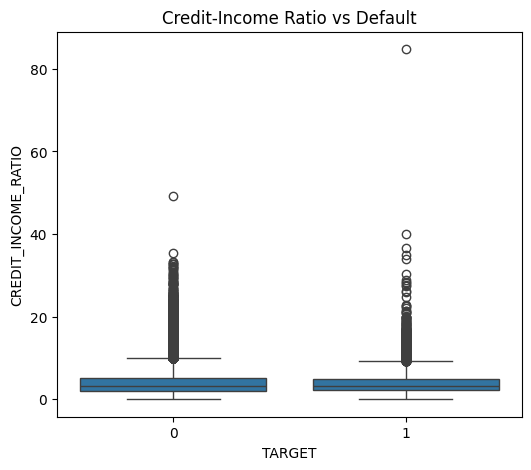

In [ ]:
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x='TARGET', y='CREDIT_INCOME_RATIO')
plt.title('Credit-Income Ratio vs Default')
plt.show()

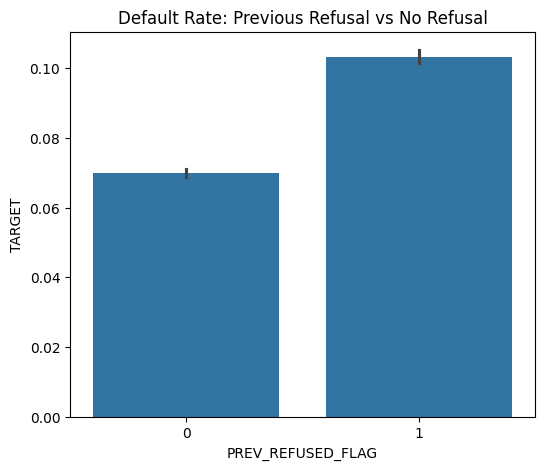

In [ ]:
plt.figure(figsize=(6,5))
sns.barplot(data=df, x='PREV_REFUSED_FLAG', y='TARGET')
plt.title('Default Rate: Previous Refusal vs No Refusal')
plt.show()

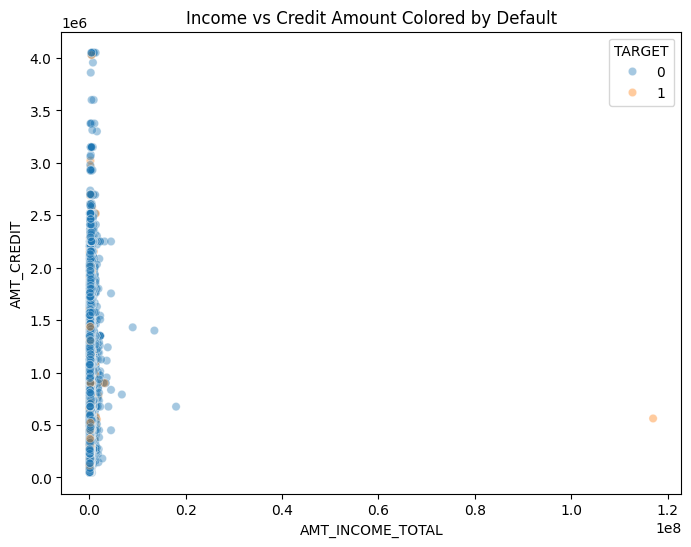

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='AMT_INCOME_TOTAL', y='AMT_CREDIT', hue='TARGET', alpha=0.4)
plt.title('Income vs Credit Amount Colored by Default')
plt.show()

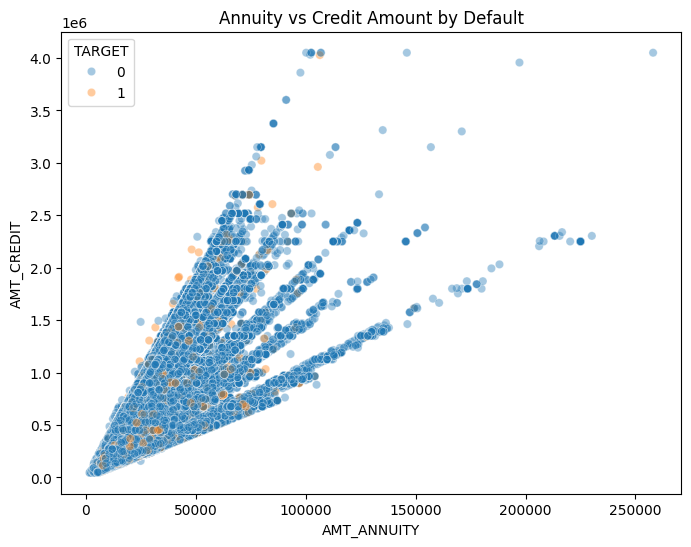

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='AMT_ANNUITY', y='AMT_CREDIT', hue='TARGET', alpha=0.4)
plt.title('Annuity vs Credit Amount by Default')
plt.show()

Using these features: ['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']


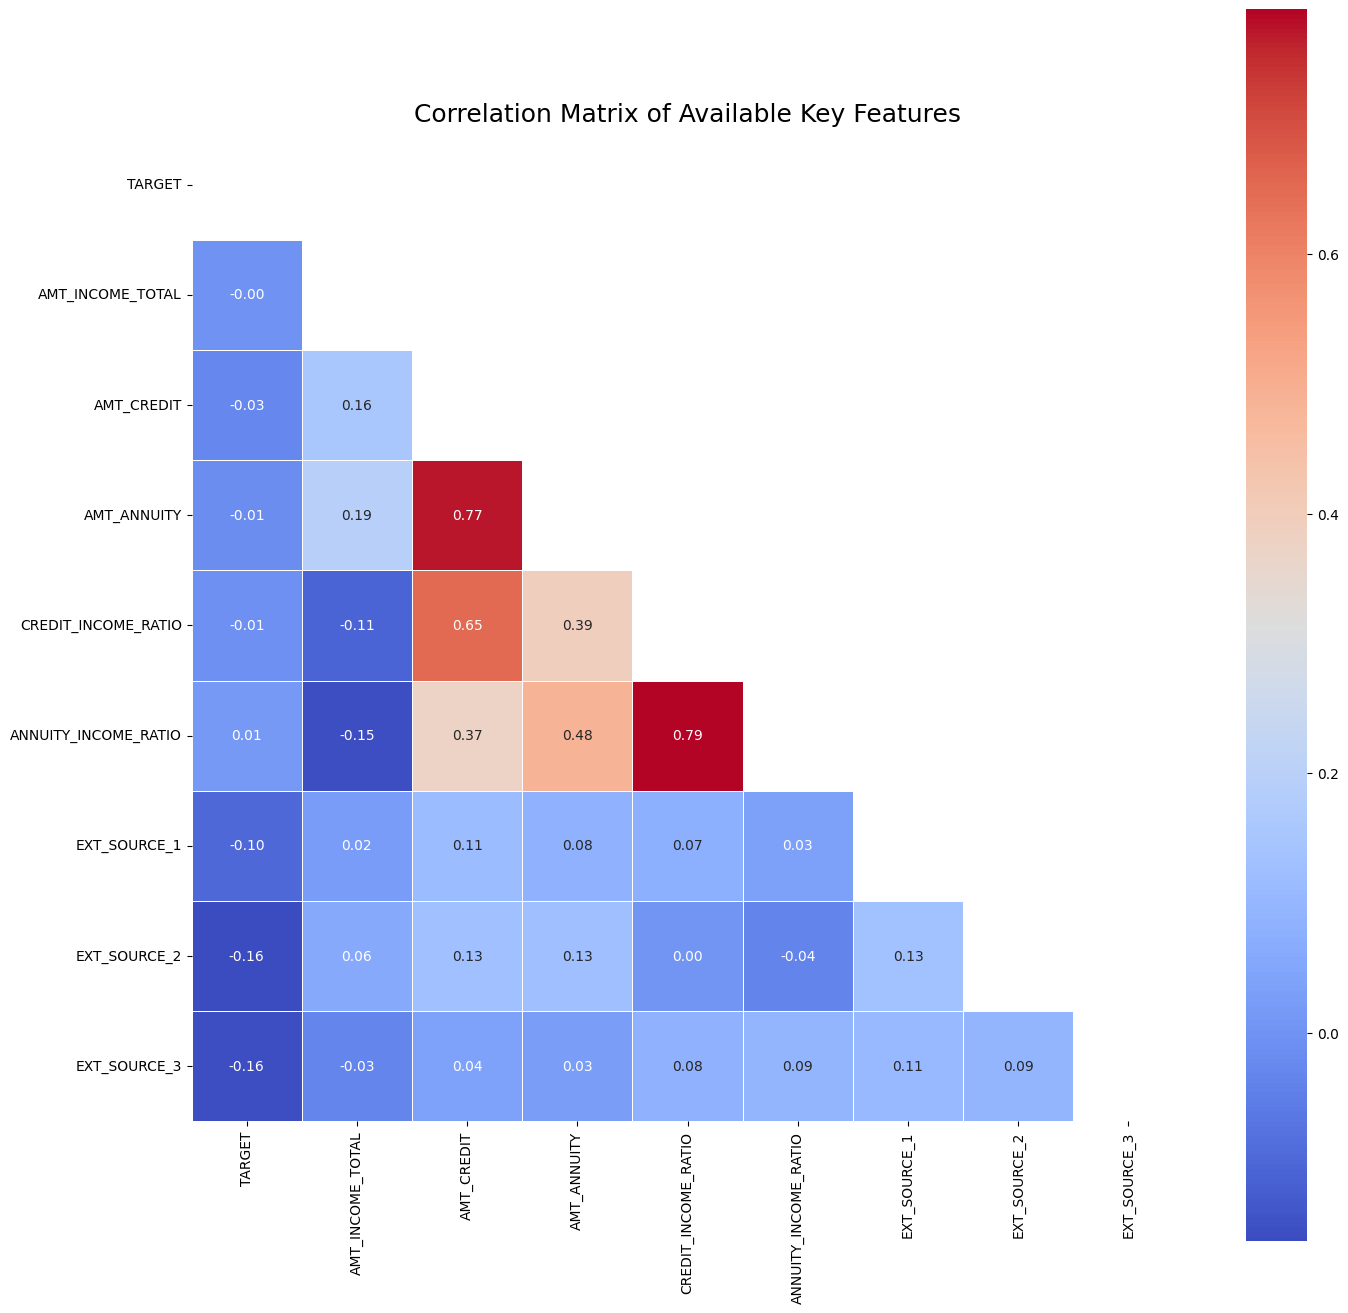

In [ ]:
# Keep only the columns that exist in your dataframe
available_features = [col for col in key_features if col in df.columns]

print("Using these features:", available_features)

corr = df[available_features].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16,16))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.7,
    square=True,
    cbar=True
)

plt.title("Correlation Matrix of Available Key Features", fontsize=18)
plt.show()

T-Test: Do defaulters have significantly different income?
Hypothesis

H₀: Mean income of defaulters = mean income of non-defaulters

H₁: Mean income differs between defaulters and non-defaulters

In [ ]:
from scipy.stats import ttest_ind

defaulters = df[df['TARGET'] == 1]['AMT_INCOME_TOTAL']
non_defaulters = df[df['TARGET'] == 0]['AMT_INCOME_TOTAL']

t_stat, p_val = ttest_ind(defaulters, non_defaulters, equal_var=False)
print("T-statistic:", t_stat)
print("p-value:", p_val)

T-statistic: 0.7896214675608348
p-value: 0.4298191958227874


p-value (0.43) > 0.05 → No significant difference in income.
Conclusion:
- Income does NOT meaningfully differ between defaulters and non-defaulters.
- Income alone is not a reliable predictor of default risk.
- Other factors such as: previous refusals, credit-income ratio, and employment stability should be
prioritized in risk assessment.

In [ ]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(df['CODE_GENDER'], df['TARGET'])
chi2, p, dof, ex = chi2_contingency(ct)

print(ct)
print("Chi-square:", chi2)
print("p-value:", p)

TARGET           0     1
CODE_GENDER             
F            20176  1514
M            10173  1148
Chi-square: 99.78149881141943
p-value: 1.7017252482309282e-23


Chi-Square Test: Is default rate different across genders?
Hypothesis

H₀: Default rate is independent of gender

H₁: Default rate differs between genders

p-value (~1.7e-23) < 0.05 → Gender and default are significantly associated.

Conclusion:
- Default rates differ between males and females.
- Gender shows a statistically significant relationship with default behavior, though it should not be used directly in lending decisions due to fairness/ethical constraints.

In [ ]:
edu_tab = pd.crosstab(df['NAME_EDUCATION_TYPE'], df['TARGET'])
chi2, p, dof, ex = chi2_contingency(edu_tab)

print(edu_tab)
print("Chi2:", chi2)
print("p-value:", p)

TARGET                             0     1
NAME_EDUCATION_TYPE                       
Academic degree                   15     0
Higher education                7645   413
Incomplete higher                992    90
Lower secondary                  361    45
Secondary / secondary special  21336  2114
Chi2: 128.86803603622886
p-value: 6.799314301870581e-27


Chi-Square Test: Is education level associated with default?

Hypothesis

H₀: Default rate is independent of education level

H₁: Default rate varies across education categories

p-value (~6.8e-27) < 0.05 → Education level and default are significantly associated.

Conclusion:
- Default rates vary meaningfully across education categories.
- Applicants with lower education levels show higher default risk.
- Education acts as an important socio-economic indicator and should be considered in risk assessment.


In [ ]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

df['HAS_PREV_REFUSAL'] = (df['NAME_CONTRACT_STATUS_Refused'] > 0).astype(int)

refused_defaults = df[df['HAS_PREV_REFUSAL']==1]['TARGET'].sum()
refused_total    = df[df['HAS_PREV_REFUSAL']==1].shape[0]

notref_defaults = df[df['HAS_PREV_REFUSAL']==0]['TARGET'].sum()
notref_total    = df[df['HAS_PREV_REFUSAL']==0].shape[0]

counts = np.array([refused_defaults, notref_defaults])
nobs    = np.array([refused_total, notref_total])

z_stat, p_val = proportions_ztest(counts, nobs)

print("Z-statistic:", z_stat)
print("p-value:", p_val)

Z-statistic: 2.206540017760816
p-value: 0.027346211501936262



Proportion Z-Test: Do customers with previous refusals default more?
Hypothesis

H₀: Default proportion is the same for customers with & without past refusals

H₁: Customers with past refusals have higher default proportion

p-value (0.027) < 0.05 → Previous refusals significantly increase default risk.

Conclusion:
- Customers who had past loan refusals show a higher default proportion comparedto customers with no refusal history.
- Past rejection behavior is an important predictor of credit risk and should be included in approval scoring.


In [ ]:
ct_prev = pd.crosstab(df['HAS_PREV_REFUSAL'], df['TARGET'])
chi2, p, dof, expected = chi2_contingency(ct_prev)

print(ct_prev)
print("Chi-square:", chi2)
print("p-value:", p)

TARGET                0     1
HAS_PREV_REFUSAL             
0                 29792  2597
1                   557    65
Chi-square: 4.546302252994406
p-value: 0.032989918782189584


Chi-Square: Association Between Past Rejections & Default

Hypothesis

H₀: No association between previous refusals and default

H₁: Previous refusals and default are associated

p-value (0.033) < 0.05 → Previous refusals and default are significantly associated.

Conclusion:
- Applicants with past loan refusals show a higher default rate than those without refusals.
- This indicates previous rejection history is an important behavioral
risk factor and should be considered in credit assessment.


In [ ]:
#Do the mean default values differ between education levels?
# Collect TARGET values for each education group
groups = [df[df['NAME_EDUCATION_TYPE'] == edu]['TARGET']
          for edu in df['NAME_EDUCATION_TYPE'].unique()]

# Run ANOVA
f_stat, p_val = stats.f_oneway(*groups)

print("F-statistic:", f_stat)
print("p-value:", p_val)

F-statistic: 255.64646742730986
p-value: 1.0586928232855088e-219


ANOVA — Education Level vs Default Rate

Hypotheses:
- H0: Mean default rate is the same for all education levels.
- H1: At least one education level has a different default rate.

Since the p-value = 1.05 × 10⁻²¹⁹, which is far below 0.05, we reject the null hypothesis.

Conclusion:
Default rates vary significantly across education levels. Some education groups show much higher default risk than others.
